In [176]:
# import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import contextily as ctx

In [177]:
# load geometry with municipalities
kom = gpd.read_file("kom/kommuner.geojson")
#kom = gpd.read_file("kom/KOMMUNE.shp", usecols=["KOMNAVN"]) # this is too detailed geometry
kom = kom.dissolve(by="KOMNAVN")
print(kom.keys())
print(kom.shape)
# convert map format so we can create background maps
kom = kom.to_crs(epsg=3857)
kom.head()

Index(['geometry', 'KOMKODE'], dtype='object')
(99, 2)


,geometry,KOMKODE
KOMNAVN,,
Aabenraa,MULTIPOLYGON Z (((1063416.145 7383400.239 -999...,0580
Aalborg,MULTIPOLYGON Z (((1068962.138 7756050.036 -999...,0851
Aarhus,"POLYGON Z ((1112840.735 7594076.059 -999.000, ...",0751
Albertslund,"POLYGON Z ((1375055.919 7499834.873 -999.000, ...",0165
Allerød,"POLYGON Z ((1371283.594 7535169.945 -999.000, ...",0201


In [178]:
# load data for last day in dataset - includes no. of residents
col_to_load = ["Kommune_(navn)", "Befolkningstal", "Kumulativ_incidens_(per_100000)"]
cases = pd.read_csv("data/Municipality_test_pos.csv", sep=";", thousands=".", usecols=col_to_load)
cases = cases.rename(columns={"Kommune_(navn)":"Kommune", "Kumulativ_incidens_(per_100000)":"Kum_incidens"})
cases.head()

,Kommune,Befolkningstal,Kum_incidens
0,København,632340,900
1,Frederiksberg,104305,924
2,Ballerup,48602,862
3,Brøndby,35090,1362
4,Dragør,14494,338


In [179]:
def merge_case_data(kom, cases):
    # merge latest daily case data for plotting
    case_data = kom.merge(cases, left_on="KOMNAVN", right_on="Kommune")
    case_data.head()
    return case_data
case_data = merge_case_data(kom, cases)

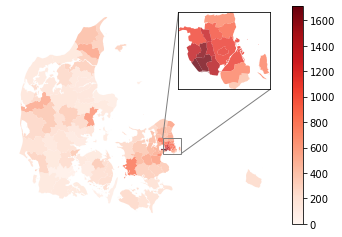

In [180]:
# test plot cases - only last day
fig, ax = plt.subplots(1,1)

# municipalities around copenhagen, used for zoomed inset map
hs_kom = ["København", "Frederiksberg", "Tårnby", "Dragør", "Hvidovre", "Brøndby", "Rødovre", "Glostrup", "Herlev", "Gladsaxe", "Gentofte", "Vallensbæk", "Albertslund", "Ballerup", "Lyngby-Taarbæk"]
case_data.plot(column="Kum_incidens", ax=ax, legend=True, cmap='Reds', alpha=0.8)
# add basemap
#ctx.add_basemap(ax, zoom=9, source=ctx.providers.Esri.WorldGrayCanvas)
# create zoomed inset, define limits and plot
axins = zoomed_inset_axes(ax, 5, loc=1)
minx,miny,maxx,maxy = case_data.query("Kommune in " + str(hs_kom)).total_bounds
axins.set_xlim(minx, maxx)
axins.set_ylim(miny, maxy)
case_data.query("Kommune in " + str(hs_kom)).plot(column="Kum_incidens", 
                                                  ax=axins, 
                                                  cmap="Reds", 
                                                  alpha=0.8,
                                                  vmin=0, vmax=1400)
#ctx.add_basemap(axins, zoom=12, source=ctx.providers.Esri.WorldGrayCanvas)
# mark lines from map to zoom
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.setp(axins, xticks=[])
plt.setp(axins, yticks=[])

ax.set_axis_off()
plt.show()
#plt.savefig("out/test.png", dpi=600, bbox_inches="tight")

In [181]:
def load_ts(file):
    """Load timeseries data and modify it so it's useful for plotting"""
    ts = pd.read_csv(file, sep=";", thousands=".")
    # rename copenhagen and transpose to have each date as columns
    ts = ts.rename(columns={"Copenhagen":"København"}).transpose(copy=True)
    # rename date columns
    ts = ts.rename(columns=ts.iloc[0]).drop(ts.index[0])
    # reset the index (municipality name) and rename that 
    ts = ts.reset_index().rename(columns={"index":"Kommune"})
    ts.columns = ts.columns[:1].tolist() + pd.to_datetime(ts.columns[1:]).tolist()
    return ts

# load infected and tested time series data
ts_infected = load_ts("data/Municipality_cases_time_series.csv")
ts_tested = load_ts("data/Municipality_tested_persons_time_series.csv")

# adjust tested dates to match infected dates
ts_tested = ts_tested.drop(ts_tested.columns[1:ts_tested.columns.get_loc(ts_infected.columns[1])], axis=1)

# create timeseries with ratio of positive tests
pos_test = ts_infected.iloc[:,1:].sum(axis=0) * 100 / ts_tested.iloc[:,1:].sum(axis=0)
#ts_tested.head()

(737481.0, 737696.0)


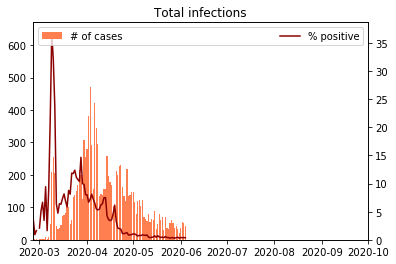

In [185]:
# test plot of time series data
figd, axd = plt.subplots(1,1)

def plot_time_series_data(axd, end_index):
    date_lim = [ts_infected.columns[1].date(), ts_infected.columns[-1].date()]

    #end_index = len(ts_infected.columns)
    lnd = axd.bar([x.date() for x in ts_infected.columns[1:end_index].tolist()], ts_infected.iloc[:,1:end_index].sum(axis=0), color="coral", label="# of cases")
    #axd.legend(loc=0)
    axd.set_ylim([0, ts_infected.iloc[:,1:].sum(axis=0).max()+20])

    #plot positive percentage
    axp = axd.twinx()
    lnp = axp.plot([x.date() for x in pos_test.index[0:end_index].tolist()], pos_test[0:end_index], color="darkred", label="% positive")
    #axd.set_ylabel("Confirmed cases")
    #axp.set_ylabel("Percent positive")
    axp.set_ylim([0, pos_test.max()+2])
    lns = [lnd]+lnp
    labs = [l.get_label() for l in lns]
    axp.legend(lns, labs, loc="upper center", mode="expand", ncol=2)
    axp.set_xlim(date_lim)
    axd.set_title("Total infections")
    return axd, axp

plot_time_series_data(axd, 100)

plt.show()

In [ ]:
# fig, (axt, axm) = plt.subplots(2,1, figsize=(8,12), gridspec_kw={"height_ratios": [1,2.5]})

fig.suptitle("Covid-19 cases in Denmark until "+ str(ts_infected.columns[-1].date()), fontsize=20)

#legend for the map
plt.axis("off")
divider = make_axes_locatable(axm)
cax = divider.append_axes("right", size="1%", pad=0.1)

hs_kom = ["København", "Frederiksberg", "Tårnby", "Dragør", "Hvidovre", "Brøndby", "Rødovre", "Glostrup", "Herlev", "Gladsaxe", "Gentofte", "Vallensbæk", "Albertslund", "Ballerup", "Lyngby-Taarbæk"]
hs_kom_extra = ["Ishøj", "Høje-Taastrup", "Egedal", "Furesø", "Rudersdal", "Greve", "Solrød", "Roskilde"]

stop_at = len(ts_infected.columns) 
window = 7 # how long back are we plotting for each day

first_date_col = 5
#merge all data into one frame
case_data = merge_case_data(kom, cases)
case_data = pd.merge(case_data, ts_infected)
# calculate number of infected pr 100.000 residents
case_data.iloc[:,6:] = case_data.iloc[:,6:].mul(100000)
case_data.iloc[:,6:] = case_data.iloc[:,6:].div(case_data["Befolkningstal"], axis=0)

print("Generating {} plots...".format(stop_at-first_date_col))

# THIS FOR LOOP TAKES A LOOOOONG TIME (1hr+ for 200 plots), HAVEN'T SPENT TIME FIGURING OUT WHY
for index in range(first_date_col, stop_at):
    if index % 10 == 0:
        print(index)
    if index < window + first_date_col:
        start = first_date_col
    else:
        start = index - window
    # save date for this data
    date = case_data.iloc[:,index].name.date()
    #print(date)
    # calculate summed incidens for window week
    case_data["Kum_incidens"] = case_data.iloc[:,start:index].sum(axis=1)
    #plot map, based on the above test plot
    case_data.plot(column="Kum_incidens", 
                        #edgecolor="lightgrey",
                        ax=axm, 
                        legend=True,
                        cax=cax, 
                        cmap="Reds", 
                        vmin=0, vmax=51,
                        aspect="auto")
    
    axins = zoomed_inset_axes(axm, 5, loc=1)
    minx,miny,maxx,maxy = case_data.query("Kommune in " + str(hs_kom)).total_bounds
    axins.set_xlim(minx, maxx)
    axins.set_ylim(miny, maxy)

    case_data.query("Kommune in " + str(hs_kom+hs_kom_extra)).plot(column="Kum_incidens", 
                                                      ax=axins, 
                                                      cmap="Reds", 
                                                      vmin=0, vmax=51)
    mark_inset(axm, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    plt.setp(axins, xticks=[])
    plt.setp(axins, yticks=[])

    axm.set_axis_off()
    axm.set_title("Infections during last week per 100.000 citizens")
    # plot timeseries based on function above
    plot_time_series_data(axt, index-first_date_col+2)
    #plt.figtext(0.42,0.93,"(C) Mikkel Rath Hansen", fontsize="small")
    fig.savefig("out/plot_{:03d}.png".format(index-first_date_col), dpi=100, bbox_inches="tight")
    plt.close()
    
print("Done")